In [1]:
import geopandas
import matplotlib.pyplot as plt
import contextily
import pandas as pd


# Visualise Well Depth Data

Text(0, 0.5, 'Water Level +/- MSL')

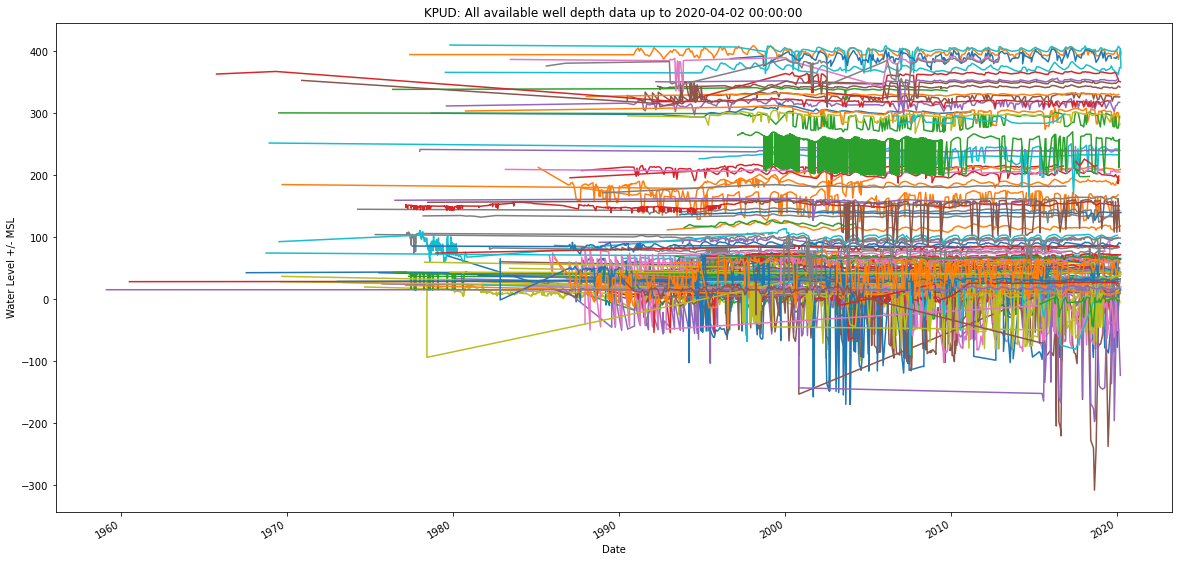

In [11]:
import pandas as pd
filename = "KPUD_Well_Depth_2020_04_05.csv"
well_depths=pd.read_csv(filename, index_col=0)
well_depths.index = pd.to_datetime(well_depths.Date)
well_depths  = well_depths.drop('Date', axis=1)

wells_in_df = well_depths['Well Name'].unique()
for i in range(len(wells_in_df)):
    well_mask = well_depths['Well Name']==wells_in_df[i]
    well_depths[well_mask]['Water Level +/- MSL'].astype(float).plot(figsize=(20,10))
plt.title('KPUD: All available well depth data up to {}'.format(well_depths.index.max()))
plt.ylabel('Water Level +/- MSL')

#  Visualise Well Locations

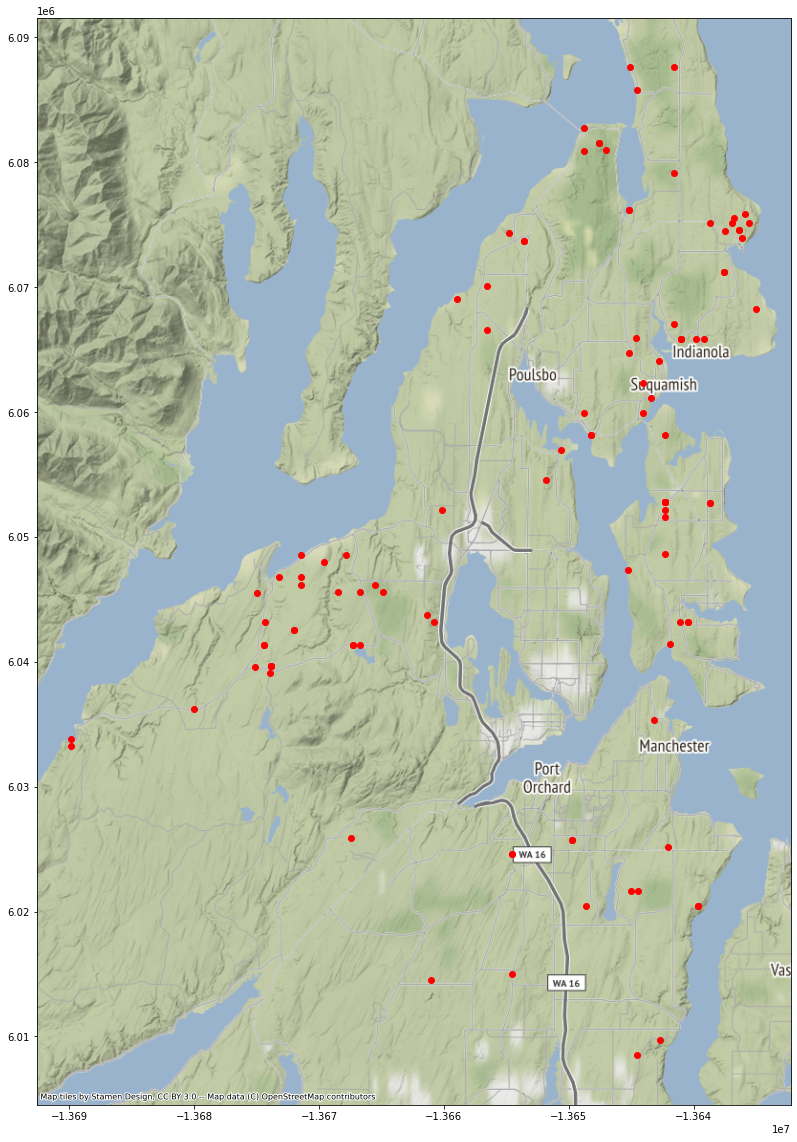

In [12]:
well_meta_data = pd.read_csv('well_meta_data.csv', index_col =0)

well_meta_data['lat'] = well_meta_data.lat.astype(float)
well_meta_data['lon'] = well_meta_data.lon.astype(float) * -1

gdf = geopandas.GeoDataFrame(well_meta_data, geometry=geopandas.points_from_xy(well_data.lon, well_data.lat))
country = geopandas.read_file("gz_2010_us_040_00_5m.json")
gdf.crs = {'init' :'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)
kitsap_wells = gdf['county_nm']=='Kitsap'
import contextily as ctx
#ax = country.plot(figsize=(20,20), alpha =0.5)
ax = gdf[kitsap_wells].plot(color='red',figsize=(20,20))
ctx.add_basemap(ax)
#plt.xlim(-1.372e7,-1.36e7)
#plt.ylim(5.95e6,6.25e6)

# Merge Meta Data and Well Depths

In [25]:

well_depths['Site_ID'] = well_depths['Well Name'].apply(lambda x: x[:6])
well_depths['Site_ID'] = well_depths['Site_ID'].str.upper()
well_depths['Date'] = well_depths.index.values



well_meta_data['Site_ID'] = well_meta_data['well_tag_nr'].str.upper()
well_cols = list(well_meta_data.columns.values)
well_cols.remove('geometry')

kitsap_meta_data = well_meta_data[well_meta_data['county_nm']=='Kitsap'][well_cols]

well_depths['Date'] = well_depths.index.values
well_master = well_depths.merge(kitsap_meta_data, left_on = 'Site_ID', right_on= 'Site_ID', how ='left')

well_master = well_master.set_index('Date')


# Try some spatial models

## Basic plot of well depths by month

In [ ]:
regrouped = well_depths.groupby('Site_ID').resample('M').max()

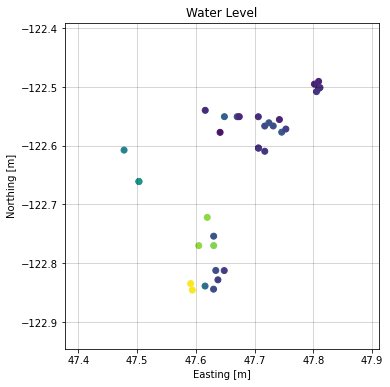

In [51]:


site_ids = well_depths['Site_ID'].unique()
agrigated  = regrouped.loc[site_ids,'Water Level +/- MSL'].reset_index()
cols =['Site_ID', 'lat', 'lon']

agrigated = agrigated.merge(kitsap_meta_data, left_on = 'Site_ID', right_on= 'Site_ID', how ='left')
month_mask = agrigated['Date'].apply(lambda x: x.month) ==6
year_mask = agrigated['Date'].apply(lambda x: x.year) == 2019
find_month = month_mask & year_mask
selected = agrigated[find_month].dropna(subset=['lat','lon','Water Level +/- MSL'])
extent = x_extent = x_min, x_max, y_min, y_max = [selected.lat.min()-0.1, selected.lat.max()+0.1,
                                                  selected.lon.min()-0.1, selected.lon.max()+0.1]
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(selected.lat, selected.lon, c=selected['Water Level +/- MSL'])
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Water Level')
ax.grid(c='k', alpha=0.2)


In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
import numpy as np
from scipy.interpolate import griddata


## Basic Interpolation Methods

Text(0.5, 1.0, 'Cubic')

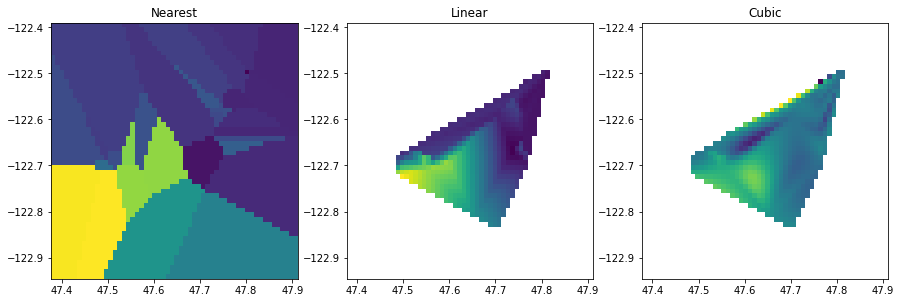

In [52]:
grid_x, grid_y = np.mgrid[x_min:x_max:0.01, y_min:y_max:0.01]

X = selected[['lat','lon']].values
y = selected['Water Level +/- MSL'].values

grid_z0 = griddata(X, y, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(X, y, (grid_x, grid_y), method='linear')
grid_z2 = griddata(X, y, (grid_x, grid_y), method='cubic')

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0, origin='lower', extent=extent)
#ax.scatter(X, y, s=2, c='w')
ax.set_title('Nearest')

ax = axs[1]
ax.imshow(grid_z1, origin='lower', extent=extent)
#ax.scatter(X, y, s=2, c='w')
ax.set_title('Linear')

ax = axs[2]
ax.imshow(grid_z2, origin='lower', extent=extent)
#ax.scatter(X, y, s=2, c='w')
ax.set_title('Cubic')

## Kriging: AKA GaussianRegressor

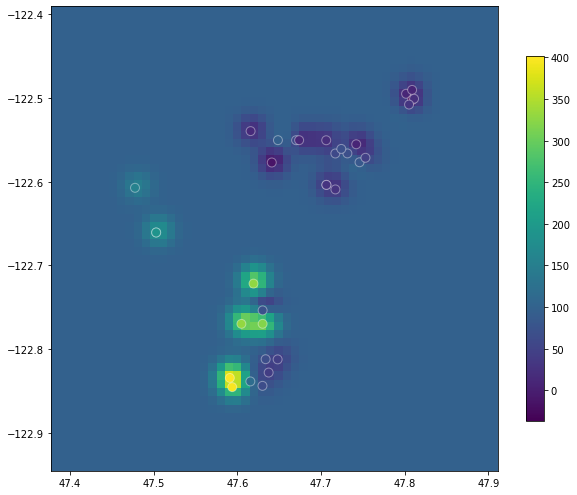

In [53]:
kernel = RBF(length_scale=1050)
model = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.101,  # Larger values imply more noise in the input data.
                              kernel=kernel)

X = selected[['lat','lon']].values
y= selected['Water Level +/- MSL'].values
model.fit(X,y)
X_grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T
y_grid = model.predict(X_grid).reshape(grid_x.shape)

mi = np.min(np.hstack([y_grid.ravel(), selected['Water Level +/- MSL']]))
ma = np.max(np.hstack([y_grid.ravel(), selected['Water Level +/- MSL']]))

# Plot it all.
plt.figure(figsize=(10,10))
im = plt.imshow(y_grid.T, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(selected.lat, selected.lon, c=selected['Water Level +/- MSL'], s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

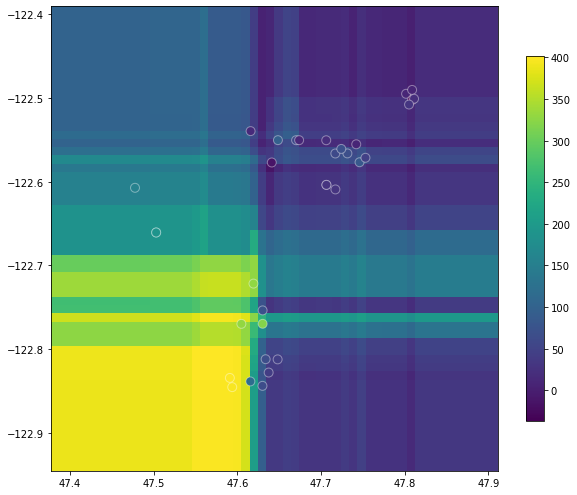

In [63]:
model = GradientBoostingRegressor(n_estimators = 200)

X = selected[['lat','lon']].values
y= selected['Water Level +/- MSL'].values
model.fit(X,y)
X_grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T
y_grid = model.predict(X_grid).reshape(grid_x.shape)

mi = np.min(np.hstack([y_grid.ravel(), selected['Water Level +/- MSL']]))
ma = np.max(np.hstack([y_grid.ravel(), selected['Water Level +/- MSL']]))

# Plot it all.
plt.figure(figsize=(10,10))
im = plt.imshow(y_grid.T, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(selected.lat, selected.lon, c=selected['Water Level +/- MSL'], s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

In [33]:
agrigated = agrigated.merge(kitsap_meta_data, left_on = 'Site_ID', right_on= 'Site_ID', how ='left')

In [36]:
month_mask = agrigated['Date'].apply(lambda x: x.month) ==6
year_mask = agrigated['Date'].apply(lambda x: x.year) == 2019
find_month = month_mask & year_mask
selected = agrigated[find_month]

In [37]:
selected

,Site_ID,Date,Water Level +/- MSL,well_log_id,well_tag_nr,nit_id_nr,well_depth_qt,well_diameter_qt,well_owner_nm,township_nr,...,qtr_qtr_section_cd,well_comp_dt,county_nm,well_type_cd,well_log_recv_dt,tax_parcel_nr,ST_PLANE_XCOORD_NR,ST_PLANE_YCOORD_NR,lat,lon
527,AAA001,2019-06-30,NaN,66892.0,AAA001,NaN,746.0,16.0,KITSAP COUNTY P U D #1,26.0,...,NW,07/03/1975,Kitsap,W,NaN,NaN,1117063.0,869911.0,47.699297,-122.625306
906,AAA002,2019-06-30,NaN,66895.0,AAA002,NaN,1032.0,20.0,KITSAP COUNTY P.U.D.,25.0,...,NW,NaN,Kitsap,W,10/24/1988,NaN,1114221.0,864701.0,47.684811,-122.636268
2746,AAA011,2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3117,AAA012,2019-06-30,NaN,66904.0,AAA012,NaN,805.0,10.0,KITSAP COUNTY PUD #1,27.0,...,NW,04/26/1989,Kitsap,W,05/05/1989,NaN,1146649.0,900439.0,47.785072,-122.508368
4351,AAA015,2019-06-30,62.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59514,AFC506,2019-06-30,NaN,248192.0,AFC506,W121592,451.0,12.0,PUD NO 1 OF KITSAP COUNTY,27.0,...,NE,12/13/1999,Kitsap,W,04/07/2000,NaN,1111480.0,906938.0,47.800337,-122.652068
59714,AHB466,2019-06-30,NaN,368026.0,AHB466,W168675,71.0,6.0,STEVE VELIE,27.0,...,NW,05/27/2003,Kitsap,W,08/11/2003,262702-2-033-2000,1144330.0,909205.0,47.808929,-122.518709
59995,ALK129,2019-06-30,31.11,549360.0,ALK129,W238916,440.0,16.0,KITSAP CO PUD 1,27.0,...,SW,04/04/2007,Kitsap,W,09/22/2008,262702-1-046-2007,1146949.0,907810.0,47.805290,-122.507912
60158,ALK301,2019-06-30,NaN,727423.0,ALK301,W238906,743.0,12.0,KITSAP PUD,25.0,...,NW,09/08/2006,Kitsap,W,06/10/2011,NaN,1068774.0,839473.0,47.612167,-122.817665
